In [1]:
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import gc
import time
from contextlib import contextmanager
import warnings
import mlflow.sklearn
import re


from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, make_scorer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline


# Préprocessuing et Feature engineering

In [2]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [4]:
# Preprocess application_train.csv
def application_train_test(df_path, num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(df_path, nrows= num_rows)
    # test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Dataframe lengh: {}".format(len(df)))
    # df = pd.concat([df, test_df], ignore_index=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature]) #remplace des str par des nombres
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    # del test_df
    gc.collect()
    return df

In [5]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


In [6]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


In [7]:
def run_full_feature_engineering(df_path, debug = False):
    # Si debug=True, on ne charge que 10000 lignes pour tester vite
    num_rows = 10000 if debug else None
    
    # 1. On prépare la table principale
    print("Processing application train/test...")
    df = application_train_test(df_path, num_rows)
    print("Main table shape:", df.shape)
    
    # 2. On traite 'bureau' et on FUSIONNE (Left Join) sur SK_ID_CURR
    print("Processing bureau...")
    bureau = bureau_and_balance(num_rows)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau; gc.collect() # Important pour libérer la mémoire
    
    # 3. Idem pour les demandes précédentes
    print("Processing previous applications...")
    prev = previous_applications(num_rows)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev; gc.collect()
    
    # 4. Idem pour POS_CASH
    print("Processing POS-CASH balance...")
    pos = pos_cash(num_rows)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos; gc.collect()
    
    # 5. Idem pour les paiements échelonnés
    print("Processing installments payments...")
    ins = installments_payments(num_rows)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins; gc.collect()
    
    # 6. Idem pour les cartes de crédit
    print("Processing credit card balance...")
    cc = credit_card_balance(num_rows)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc; gc.collect()
    
    print("Final DataFrame shape:", df.shape)
    # On retourne le gros DataFrame final, prêt pour le Machine Learning
    return df

In [8]:
#Application de tout ce processus
train_df = run_full_feature_engineering(df_path = "application_train.csv", debug=False)

Processing application train/test...
Dataframe lengh: 307511


C:\Users\manon\AppData\Local\Temp\ipykernel_23892\1766750248.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)


Main table shape: (307507, 247)
Processing bureau...
Processing previous applications...


C:\Users\manon\AppData\Local\Temp\ipykernel_23892\4260659478.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
C:\Users\manon\AppData\Local\Temp\ipykernel_23892\4260659478.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

Processing POS-CASH balance...
Processing installments payments...
Processing credit card balance...
Final DataFrame shape: (307507, 797)


In [9]:
train_df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
train_df.isna().mean()

SK_ID_CURR                          0.000000
TARGET                              0.000000
CODE_GENDER                         0.000000
FLAG_OWN_CAR                        0.000000
FLAG_OWN_REALTY                     0.000000
                                      ...   
CC_NAME_CONTRACT_STATUS_nan_MAX     0.717389
CC_NAME_CONTRACT_STATUS_nan_MEAN    0.717389
CC_NAME_CONTRACT_STATUS_nan_SUM     0.717389
CC_NAME_CONTRACT_STATUS_nan_VAR     0.719444
CC_COUNT                            0.717389
Length: 797, dtype: float64

In [46]:
train_df.to_parquet('train_df.parquet') #plus besoin de refaire le feature engineering à chaque fois

# Début de l'exploration des modèles

## Plus besoin de refaire tourner le feature engineering

In [11]:
data = pd.read_parquet('train_df.parquet')
data.shape

(307507, 797)

In [12]:
# Séparation des données pour créer le jeu de données train et test
X = data.drop(columns=['TARGET'])
y = data['TARGET']

X.shape, y.shape

del data
gc.collect()

#Le jeu de données test représente 20% des données totales
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_temp.shape, y_temp.shape)
print(X_test.shape, y_test.shape)

(246005, 796) (246005,)
(61502, 796) (61502,)


In [ ]:
#Enregistrer mes tests en csv (fichier) pour soulager la mémoire
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

X_test.to_csv('X_test.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')


In [5]:
print(f"Entraînement : {X_temp.shape[0]} lignes")
print(f"Test : {X_test.shape[0]} lignes")

del X, y, X_test, y_test
gc.collect()

Entraînement : 246005 lignes
Test : 61502 lignes


0

### Pour le modèle choisi

In [ ]:
# Séparation du train en train et val pour avoir un jeu de données de  validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)
X_train = X_train.drop(columns=['SK_ID_CURR'])
X_val = X_val.drop(columns=['SK_ID_CURR'])
print(f"Taille du nouveau jeu d'entraînement : {X_train.shape, y_train.shape}")
print(f"Taille du jeu de validation : {X_val.shape, y_val.shape}")

Taille du nouveau jeu d'entraînement : ((184503, 795), (184503,))
Taille du jeu de validation : ((61502, 795), (61502,))


### Pour tester les modèles plus rapidement

In [7]:
X_small, X_notused, y_small, y_notused = train_test_split(
    X_temp, y_temp, test_size=0.8, random_state=42, stratify=y_temp
)

print(f"Taille du jeu d'entraînement pour tester les modèles: {X_small.shape, y_small.shape}")
print(f"Vérification: {X_notused.shape, y_notused.shape}")

Taille du jeu d'entraînement pour tester les modèles: ((49201, 795), (49201,))
Vérification: ((196804, 795), (196804,))


In [ ]:
X_train_small, X_val_small, y_train_small, y_val_small = train_test_split(
    X_small, y_small, test_size=0.25, random_state=42, stratify=y_small
)

X_train_small = X_train_small.drop(columns=['SK_ID_CURR'])
X_val_small = X_val_small.drop(columns=['SK_ID_CURR'])
print(f"Taille du nouveau jeu d'entraînement : {X_train_small.shape, y_train_small.shape}")
print(f"Taille du jeu de validation : {X_val_small.shape, y_val_small.shape}")

Taille du nouveau jeu d'entraînement : ((36900, 795), (36900,))
Taille du jeu de validation : ((12301, 795), (12301,))


In [9]:
#Enregistrer mes tests en parquet (fichier) pour soulager la mémoire
X_train.to_parquet('X_train.parquet')
X_val.to_parquet('X_val.parquet')
pd.DataFrame(y_train).to_parquet('y_train.parquet')
pd.DataFrame(y_val).to_parquet('y_val.parquet')

X_train_small.to_parquet('X_train_small.parquet')
X_val_small.to_parquet('X_val_small.parquet')
pd.DataFrame(y_train_small).to_parquet('y_train_small.parquet')
pd.DataFrame(y_val_small).to_parquet('y_val_small.parquet')


del X_temp, y_temp
gc.collect()

0

## Initialisationh de l'environnement MLFlow

In [15]:
mlflow.set_experiment("Elaboration du modèle de scoring - P7 DS - 2")

2026/01/29 10:42:28 INFO mlflow.tracking.fluent: Experiment with name 'Elaboration du modèle de scoring - P7 DS - 2' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/manon/Documents/GitHub/OCProjet7/mlruns/267786296331635663', creation_time=1769679748072, experiment_id='267786296331635663', last_update_time=1769679748072, lifecycle_stage='active', name='Elaboration du modèle de scoring - P7 DS - 2', tags={}>

## Recherche du meilleur modèle

In [52]:
# Si besoin 
X_train = pd.read_parquet('X_train.parquet')
X_val = pd.read_parquet('X_val.parquet')
y_train = pd.read_parquet('y_train.parquet')['TARGET']
y_train = y_train.to_numpy()
y_val = pd.read_parquet('y_val.parquet')['TARGET']
y_val = y_val.to_numpy()
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((184503, 795), (184503,), (61502, 795), (61502,))

In [10]:
dumb_model = DummyClassifier(strategy="most_frequent")

In [11]:
with mlflow.start_run(run_name="Dummy Model"):
    dumb_model.fit(X_train_small, y_train_small)
    y_val_pred__dumb = dumb_model.predict_proba(X_val_small)[:, 1]
    val_auc = roc_auc_score(y_val_small, y_val_pred__dumb)
    print(f"Score AUC sur validation : {val_auc:.4f}")
    #Tracer de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_val_small, y_val_pred__dumb)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Taux de Faux Positifs')
    ax.set_ylabel('Taux de Vrais Positifs')
    ax.set_title('Courbe ROC - Modèle Dummy')
    ax.legend(loc="lower right")
    ax.grid(True)
    mlflow.log_figure(fig, "roc_curve_dumb.png")
    plt.close(fig)
    #Enregistrement du modèle dans MLflow
    mlflow.sklearn.log_model(dumb_model, "dummy_model")
    mlflow.log_param("strategy", "most_frequent")
    mlflow.log_metric("auc_score", val_auc)
    print("Run MLFlow terminé.")


2026/01/25 13:04:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Score AUC sur validation : 0.5000
Run MLFlow terminé.


In [12]:
#Le feature engineering a créé des valeur infini dan sle scolonnes résultant d'un ratio, je cherche où
X_train_numeric = X_train_small.select_dtypes(include=[np.number])

# Maintenant, on cherche les infinis
inf_columns = X_train_numeric.columns[np.isinf(X_train_numeric).any()]

print(f"Colonnes contenant des valeurs infinies : {list(inf_columns)}")
print(f"Nombre total de valeurs infinies : {np.isinf(X_train_numeric).sum().sum()}")

Colonnes contenant des valeurs infinies : ['INSTAL_PAYMENT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_SUM']
Nombre total de valeurs infinies : 3


In [18]:
# Je remplace ces valeurs par des NaN
X_train_small.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val_small.replace([np.inf, -np.inf], np.nan, inplace=True)


# Vérification rapide
cols_to_check = ['PREV_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_SUM']
print(X_train_small[cols_to_check].isin([np.inf, -np.inf]).sum())

PREV_APP_CREDIT_PERC_MAX    0
INSTAL_PAYMENT_PERC_SUM     0
dtype: int64


In [15]:
X_train_small.shape

(36900, 795)

In [16]:
mlflow.sklearn.autolog()

### Calcule du score métier

In [20]:
def calcul_score_metier(y_true, y_pred):
    # 1. Extraction des valeurs de la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    score = (10 * fn) + fp
    
    return score

In [21]:
score_metier = make_scorer(calcul_score_metier, greater_is_better=False)
score_metier

make_scorer(calcul_score_metier, greater_is_better=False, response_method='predict')

In [18]:
def pipeline_model_score_simple(model_type, X_train, y_train, X_val, y_val):
    model_name = model_type.__class__.__name__
    
    with mlflow.start_run(run_name=f"Simple_{model_name}", nested=True) as child_run:
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('model', model_type)                        
        ]

        pipeline = Pipeline(steps=steps)
        mlflow.log_params(model_type.get_params())
                
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("optimization", "None")

        pipeline.fit(X_train, y_train)
        
        # --- LOGGING DU MEILLEUR SCORE ---
        # Attention : comme greater_is_better=False, ce score sera négatif (ex: -150)
        # On prend la valeur absolue pour l'affichage si on veut
        y_train_pred = pipeline.predict(X_train)
        train_cost = calcul_score_metier(y_train, y_train_pred)
        print(f"Coût métier sur le train : {train_cost:.2f}")
        mlflow.log_metric("train_business_cost", train_cost) 

        # --- EVALUATION SUR VAL ---
        # 1. Calcul de l'AUC (on garde ça, c'est utile)
        y_val_probs = pipeline.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_probs)
        
        # 2. Calcul du COÛT RÉEL sur la validation (NOUVEAU)
        y_val_pred = pipeline.predict(X_val) # Prédictions dures (0 ou 1)
        val_cost = calcul_score_metier(y_val, y_val_pred) # On utilise ta fonction directement
        
        print(f"Score AUC sur validation : {val_auc:.4f}")
        print(f"Coût Métier sur validation : {val_cost} €") # <--- Affichage important
        
        mlflow.log_metric("val_auc", val_auc)
        mlflow.log_metric("val_business_cost", val_cost)

        # --- TRACÉ ROC (INCHANGÉ) ---
        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Taux de Faux Positifs')
        ax.set_ylabel('Taux de Vrais Positifs')
        ax.set_title(f'Courbe ROC - Modèle {model_name}')
        ax.legend(loc="lower right")
        ax.grid(True)
        
        # Log de la figure dans MLflow
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")

    return pipeline, val_auc, fig, val_cost

In [25]:
def get_param_grid(model):
    name = model.__class__.__name__  #pour trouver le type de modèle, permet à la fonction d'être dynamique et de l'utiliser pour plusieurs types de modèles
    grids = {
        "LogisticRegression": {
            'model__C': [0.01, 0.1, 1, 10],
            'model__penalty': ['l1', 'l2'],
            'model__solver': ['liblinear']
        },
        "RandomForestClassifier": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 10, None],
            'model__class_weight': ['balanced', None] #pour gérer le déséquilibre des classes
        },
        "XGBClassifier": {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [2, 3, 6],
            'model__scale_pos_weight': [1, 10], #pour gérer le déséquilibre des classes
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__random_state': [42],
            'model__use_label_encoder': [False], # Pour éviter un warning
            'model__eval_metric': ['logloss']
        }         
    }

    return grids.get(name, {})

In [20]:
def pipeline_model_score(model_type, X_train, y_train, X_val, y_val):
    model_name = model_type.__class__.__name__
    
    with mlflow.start_run(run_name=f"GS_{model_name}", nested=True) as child_run:
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('model', model_type)                        
        ]

        pipeline = Pipeline(steps=steps, verbose = True)
        param_grid = get_param_grid(model_type)
        
        print(f"Hyperparamètres pour {model_name} : {param_grid}")
        
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("mlflow.runName", f"GS_{model_name}")

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        grid_search_model = GridSearchCV(
            pipeline, 
            param_grid,
            cv=cv, 
            scoring=score_metier, 
            verbose=2, 
            n_jobs=2
        )
        
        grid_search_model.fit(X_train, y_train)
        
        # --- LOGGING DU MEILLEUR SCORE ---
        # Attention : comme greater_is_better=False, ce score sera négatif (ex: -150)
        # On prend la valeur absolue pour l'affichage si on veut
        best_cost = abs(grid_search_model.best_score_)
        print(f"Meilleur coût métier moyen sur le CV : {best_cost:.2f}")
        mlflow.log_metric("best_cv_business_cost", best_cost) # <--- On loggue ça dans MLflow

        # --- EVALUATION SUR VAL ---
        # 1. Calcul de l'AUC (on garde ça, c'est utile)
        y_val_probs = grid_search_model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_probs)
        
        # 2. Calcul du COÛT RÉEL sur la validation (NOUVEAU)
        y_val_pred = grid_search_model.predict(X_val) # Prédictions dures (0 ou 1)
        val_cost = calcul_score_metier(y_val, y_val_pred) # On utilise ta fonction directement
        
        print(f"Score AUC sur validation : {val_auc:.4f}")
        print(f"Coût Métier sur validation : {val_cost} €") # <--- Affichage important
        
        mlflow.log_metric("val_auc", val_auc)
        mlflow.log_metric("val_business_cost", val_cost)

        # --- TRACÉ ROC (INCHANGÉ) ---
        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Taux de Faux Positifs')
        ax.set_ylabel('Taux de Vrais Positifs')
        ax.set_title(f'Courbe ROC - Modèle {model_name}')
        ax.legend(loc="lower right")
        ax.grid(True)
        
        # Log de la figure dans MLflow
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")

    return grid_search_model, val_auc, fig, val_cost

In [11]:
def grid_search_lightgbm_with_early_stopping_score(X_train, y_train, X_val, y_val):
    model_name = "LGBMClassifier"
    with mlflow.start_run(run_name=f"GS_{model_name}", nested=True) as child_run:
        preprocessor = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        X_train_proc = preprocessor.fit_transform(X_train)
        X_val_proc = preprocessor.transform(X_val)
    
    # 1. On définit le modèle de base (sans hyperparamètres fixés, sauf le n_jobs)
        lgbm = lgb.LGBMClassifier(random_state=42, n_jobs=1) # n_jobs=1 pour laisser le GridSearch gérer les cœurs

    # 2. La grille de paramètres à tester
    # Note : On ne met pas de "model__" devant car il n'y a plus de pipeline !
        param_grid ={
                'n_estimators': [1000],
                'learning_rate': [0.02, 0.05],
                'num_leaves': [34, 50],
                'colsample_bytree': [0.7, 0.9],
                'subsample': [0.8, 1],
                'max_depth': [8, -1],
                'class_weight': [None, 'balanced'], #pour gérer le déséquilibre des classes
                'random_state': [42]
                }
        
        mlflow.set_tag("model_type", model_name)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 folds pour aller plus vite
            
        grid = RandomizedSearchCV(
            estimator=lgbm,
            param_distributions=param_grid,
            cv=cv,
            scoring=score_metier,
            verbose=1,
            n_jobs=2
        )

        print("🚀 Lancement du GridSearch avec Early Stopping...")
            
        grid.fit(
            X_train_proc, y_train,
            eval_set=[(X_val_proc, y_val)],        # Le jeu de validation pour l'early stopping
            eval_metric='auc', #mieux que le score directement car mon score n'est pas une variable continue
            callbacks=[                       # Les callbacks LightGBM
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=0)  # period=0 pour ne pas spammer la console à chaque essai
            ]
        )
        best_cost = abs(grid.best_score_) #car le score retourner est négatif avec greater_is_better=False
        print(f"Meilleur coût métier moyen sur le CV : {best_cost:.2f}")
        mlflow.log_metric("best_cv_business_cost", best_cost) # <--- On loggue ça dans MLflow

        clean_params = grid.best_params_.copy()
        clean_params.pop('n_jobs', None)

        clean_params = grid.best_params_.copy()
        clean_params.pop('n_jobs', None)
        clean_params.pop('random_state', None)
        
        mlflow.log_params(clean_params)
        # mlflow.log_params(grid.best_params_)
        y_val_pred = grid.predict(X_val_proc) # Prédictions dures (0 ou 1)
        y_val_probs = grid.predict_proba(X_val_proc)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_probs)
        # On calcule le coût réel sur la validation
        real_cost_val = calcul_score_metier(y_val, y_val_pred)
        
        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_title(f'Courbe ROC - Modèle {model_name}')
        ax.legend(loc="lower right")
        
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")

        print(f"✅ Meilleur score score métier (CV) : {grid.best_score_:.4f}")
        print(f"✅ Meilleurs paramètres : {grid.best_params_}")
        
        return grid.best_estimator_, val_auc, real_cost_val, fig

2026/01/25 13:14:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge

Coût métier sur le train : 28274.00
Score AUC sur validation : 0.7506
Coût Métier sur validation : 9607 €


C:\Users\manon\AppData\Local\Temp\ipykernel_5016\32485854.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_model_df = pd.concat([score_model_df, pd.DataFrame([{
2026/01/25 13:15:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missi

Coût métier sur le train : 20.00
Score AUC sur validation : 0.6924
Coût Métier sur validation : 9921 €


2026/01/25 13:16:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/25 13:16:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_projec

Coût métier sur le train : 10136.00


2026/01/25 13:17:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/25 13:17:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_projec

Score AUC sur validation : 0.7332
Coût Métier sur validation : 9480 €


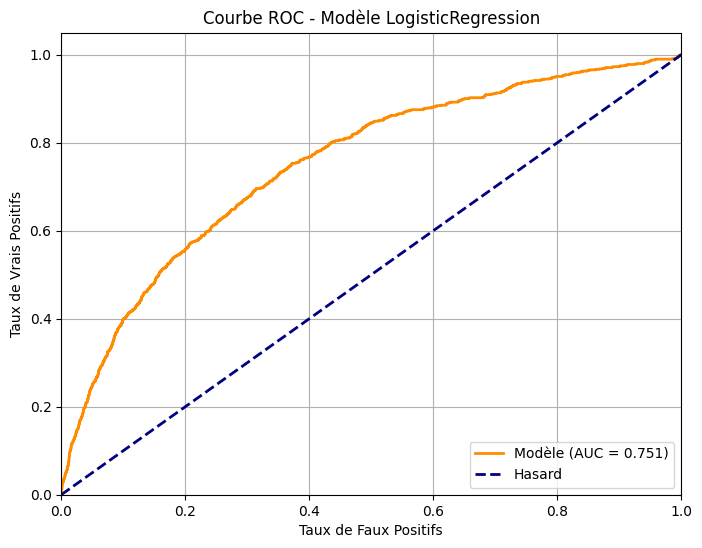

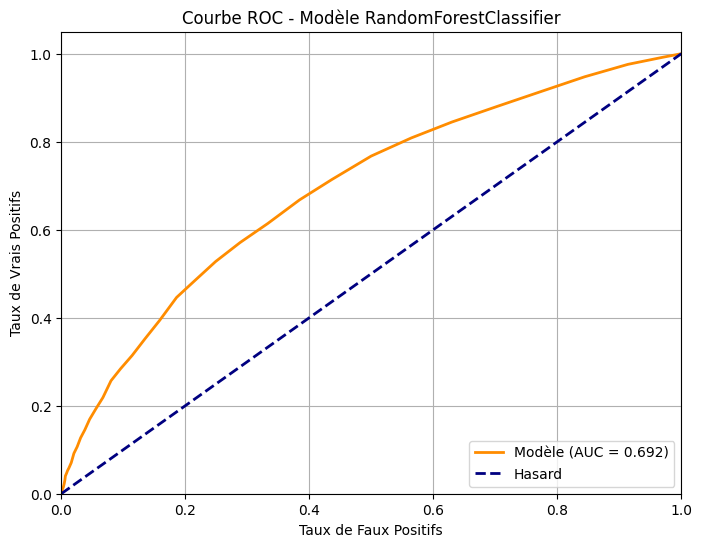

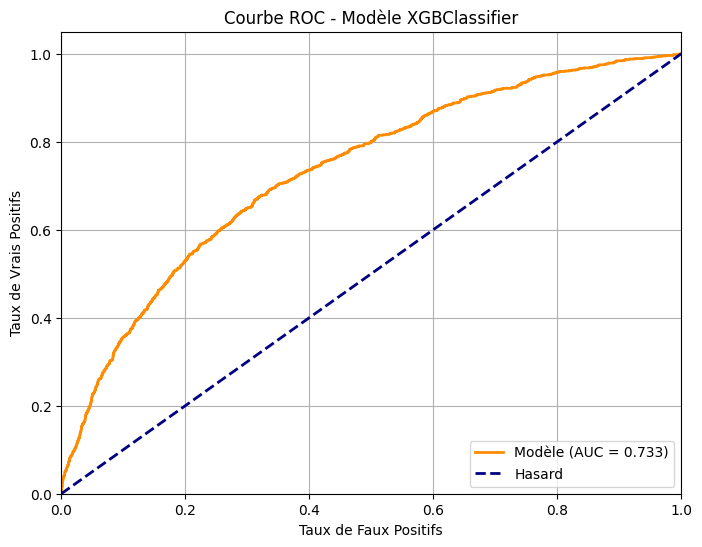

In [21]:
models_list = [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]

score_model_df = pd.DataFrame(columns=["Modèle", "AUC", "Score métier"])
for model in models_list:
    pipeline, val_auc, fig, val_cost = pipeline_model_score_simple(model, X_train_small, y_train_small, X_val_small, y_val_small)
    score_model_df = pd.concat([score_model_df, pd.DataFrame([{
        "Modèle": f"{model.__class__.__name__}_simple",
        "AUC": val_auc,
        "Score métier": val_cost
    }])], ignore_index=True)

In [22]:
print(score_model_df)

                          Modèle       AUC Score métier
0      LogisticRegression_simple  0.750616         9607
1  RandomForestClassifier_simple  0.692354         9921
2           XGBClassifier_simple  0.733200         9480


Hyperparamètres pour LogisticRegression : {'model__C': [0.01, 0.1, 1, 10], 'model__penalty': ['l1', 'l2'], 'model__solver': ['liblinear']}


2026/01/25 13:20:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   3.7s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.3s


2026/01/25 14:52:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


[Pipeline] ............. (step 3 of 3) Processing model, total=31.4min


2026/01/25 14:52:43 INFO mlflow.sklearn.utils: Logging the 5 best runs, 3 runs will be omitted.
2026/01/25 14:52:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Meilleur coût métier moyen sur le CV : 9483.33


2026/01/25 14:52:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/25 14:52:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_projec

Score AUC sur validation : 0.7473
Coût Métier sur validation : 9584 €
Hyperparamètres pour RandomForestClassifier : {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10, None], 'model__class_weight': ['balanced', None]}


2026/01/25 14:52:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   3.7s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.3s


2026/01/25 14:59:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


[Pipeline] ............. (step 3 of 3) Processing model, total=  12.8s


2026/01/25 15:00:08 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.
2026/01/25 15:00:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Meilleur coût métier moyen sur le CV : 7221.00


2026/01/25 15:00:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/25 15:00:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_projec

Score AUC sur validation : 0.7344
Coût Métier sur validation : 6803 €
Hyperparamètres pour XGBClassifier : {'model__n_estimators': [50, 100, 200], 'model__max_depth': [2, 3, 6], 'model__scale_pos_weight': [1, 10], 'model__learning_rate': [0.01, 0.05, 0.1], 'model__random_state': [42], 'model__use_label_encoder': [False], 'model__eval_metric': ['logloss']}


2026/01/25 15:00:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   3.7s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.3s


c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:32:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2026/01/25 16:32:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Intege

[Pipeline] ............. (step 3 of 3) Processing model, total=   2.1s


2026/01/25 16:33:13 INFO mlflow.sklearn.utils: Logging the 5 best runs, 49 runs will be omitted.
2026/01/25 16:33:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Meilleur coût métier moyen sur le CV : 6629.00


2026/01/25 16:33:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/25 16:33:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_projec

Score AUC sur validation : 0.7679
Coût Métier sur validation : 6320 €


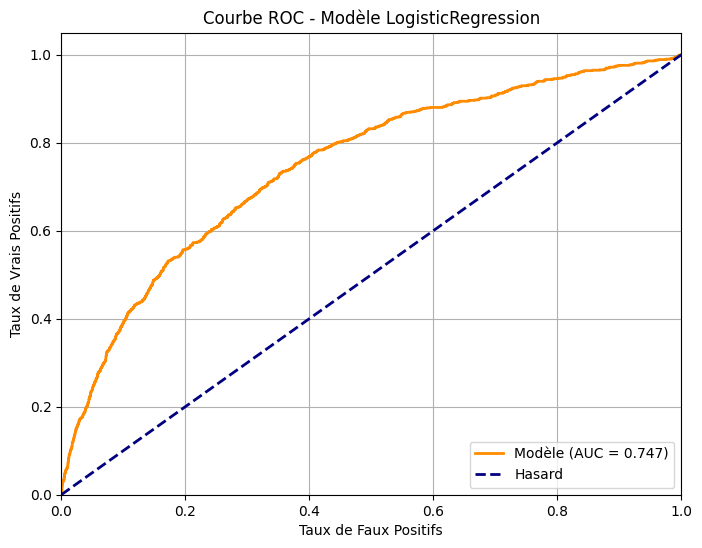

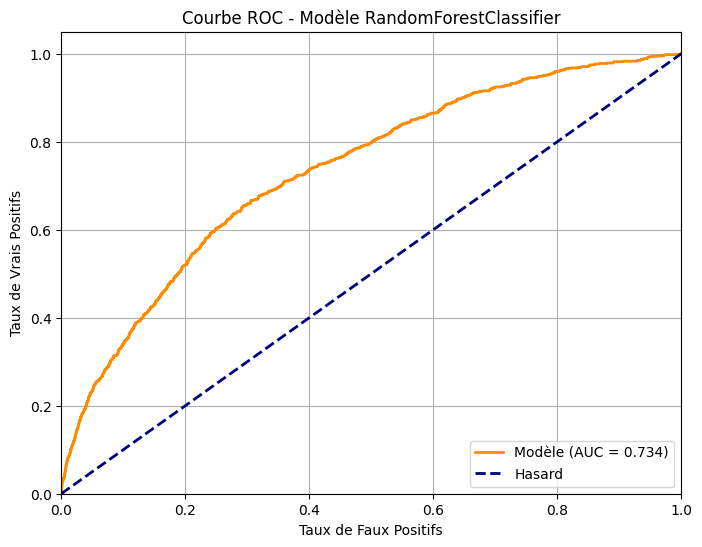

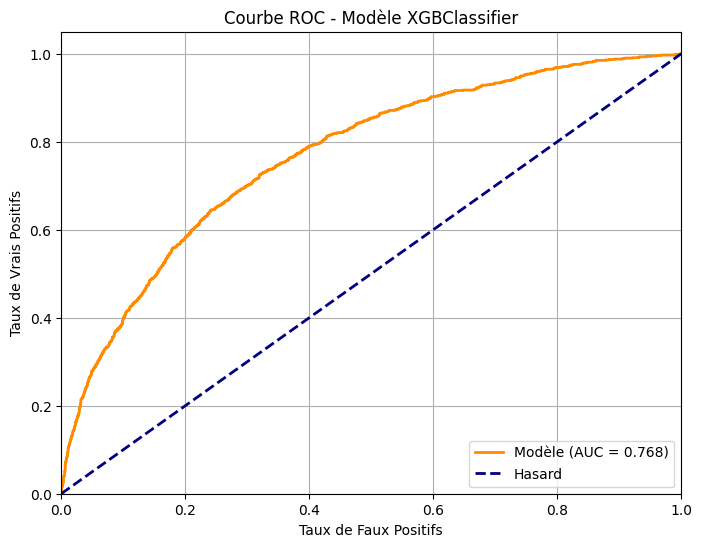

In [26]:
for model in models_list:
    grid_search_model, val_auc, fig, val_cost = pipeline_model_score(model, X_train_small, y_train_small, X_val_small, y_val_small)
    score_model_df = pd.concat([score_model_df, pd.DataFrame([{
        "Modèle": f"{model.__class__.__name__}_GS",
        "AUC": val_auc,
        "Score métier": val_cost
    }])], ignore_index=True)

2026/01/29 10:48:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/29 10:48:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site

🚀 Lancement du GridSearch avec Early Stopping...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 2979, number of negative: 33921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.059024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90307
[LightGBM] [Info] Number of data points in the train set: 36900, number of used features: 700
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[264]	valid_0's auc: 0.772318	valid_0's binary_logloss: 0.485047


c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

Meilleur coût métier moyen sur le CV : 6718.00


c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Meilleur score score métier (CV) : -6718.0000
✅ Meilleurs paramètres : {'subsample': 0.8, 'random_state': 42, 'num_leaves': 34, 'n_estimators': 1000, 'max_depth': -1, 'learning_rate': 0.02, 'colsample_bytree': 0.7, 'class_weight': 'balanced'}


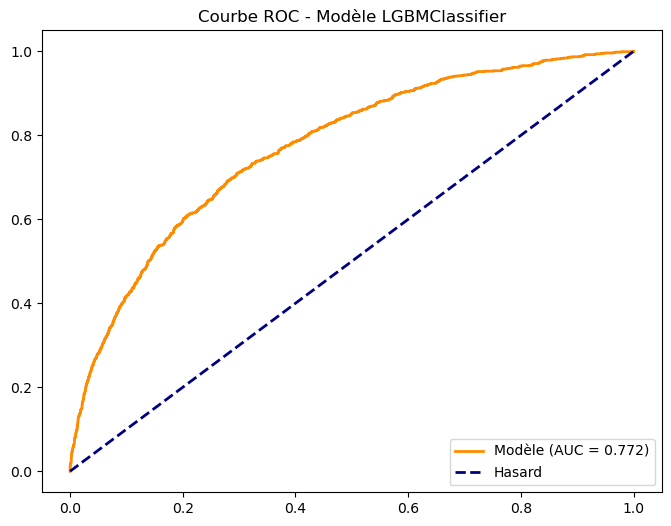

In [22]:
best_lgbmmodel, lgbm_auc, lgbm_score, fig_lgbm = grid_search_lightgbm_with_early_stopping_score(X_train_small, y_train_small, X_val_small, y_val_small)

In [29]:
score_model_df = pd.concat([score_model_df, pd.DataFrame([{
        "Modèle": "LightGBM",
        "AUC": lgbm_auc,
        "Score métier": lgbm_score
    }])], ignore_index=True)
print(score_model_df)

                          Modèle       AUC Score métier
0      LogisticRegression_simple  0.750616         9607
1  RandomForestClassifier_simple  0.692354         9921
2           XGBClassifier_simple  0.733200         9480
3          LogisticRegression_GS  0.747297         9584
4      RandomForestClassifier_GS  0.734422         6803
5               XGBClassifier_GS  0.767933         6320
6                       LightGBM  0.770800         6262


In [30]:
def pipeline_model_smote(model_type, X_train, y_train, X_val, y_val):
    model_name = model_type.__class__.__name__
    
    with mlflow.start_run(run_name=f"SMOTE_{model_name}", nested=True) as child_run:
        steps = [
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('model', model_type)
        ]

        imbpipeline = ImbPipeline(steps=steps)
        mlflow.log_params(model_type.get_params())
        mlflow.log_param("sampling_strategy", "SMOTE")

        print(f"Entraînement avec SMOTE de {model_name}...")

        imbpipeline.fit(X_train, y_train)

        # AUC
        y_val_probs = imbpipeline.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_probs)

        mlflow.log_metric("val_auc", val_auc)
        mlflow.log_metric("val_business_cost", val_cost)

        # Graphique
        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_title(f'Courbe ROC - {model_name} avec SMOTE')
        ax.legend(loc="lower right")
        ax.grid(True)
        
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")
        plt.close(fig)

    return imbpipeline, val_auc, fig, val_cost

In [31]:
import datetime


def smote_lightgbm_with_early_stopping_score(X_train, y_train, X_val, y_val):
    model_name = "LGBMClassifier"
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    with mlflow.start_run(run_name=f"SMOTE_{model_name}_{timestamp}", nested=True) as child_run:
        preprocessor = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        X_train_proc = preprocessor.fit_transform(X_train)
        X_val_proc = preprocessor.transform(X_val)
    
        smote = SMOTE(random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train_proc, y_train)

        lgbm_smote = lgb.LGBMClassifier(
            n_estimators=1000,     # Nombre d'arbres
            learning_rate=0.05,    # Vitesse d'apprentissage standard
            num_leaves=31,         # Valeur par défaut classique
            random_state=42
        ) 
        
        mlflow.log_params(lgbm_smote.get_params())
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("optimization", "EarlyStopping")
        mlflow.set_tag("sampling_strategy", "SMOTE")
        
        lgbm_smote.fit(
            X_train_smote, y_train_smote,
            eval_set=[(X_val_proc, y_val)],  # Le jeu de validation sert à arrêter l'entraînement
            eval_metric='auc',               # On surveille l'AUC
            callbacks=[
                lgb.early_stopping(stopping_rounds=50), # Arrêt si pas d'amélioration pendant 50 rounds
                lgb.log_evaluation(period=100)          # Affiche le score tous les 100 arbres
            ])

        y_val_probs = lgbm_smote.predict_proba(X_val_proc)[:, 1]
        y_val_pred = lgbm_smote.predict(X_val_proc)
        
        val_auc = roc_auc_score(y_val, y_val_probs)
        val_cost = calcul_score_metier(y_val, y_val_pred) 
        
        mlflow.log_metric("val_auc", val_auc)
        mlflow.log_metric("val_business_cost", val_cost)
        mlflow.log_metric("best_iteration", lgbm_smote.best_iteration_)

        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_title(f'Courbe ROC - {model_name} (SMOTE + EarlyStop)')
        ax.legend(loc="lower right")
        ax.grid(True)
        
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")
        
        # On sauvegarde le modèle brut ici.
        mlflow.sklearn.log_model(lgbm_smote, f"model_{model_name}")
        plt.close(fig)

    return lgbm_smote, val_auc, val_cost, fig

In [33]:
imbpipeline, val_auc, fig, val_cost = pipeline_model_smote(XGBClassifier(), X_train_small, y_train_small, X_val_small, y_val_small)
score_model_df = pd.concat([score_model_df, pd.DataFrame([{
    "Modèle": "XGBClassifier_SMOTE",
    "AUC": val_auc,
    "Score métier": val_cost
}])], ignore_index=True)

Entraînement avec SMOTE de XGBClassifier...


2026/01/25 16:57:01 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/25 16:57:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/25 16:57:04 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\manon\anaconda3\envs\OC_project\Lib\

In [35]:
rfsmotepipeline, val_auc, fig, val_cost = pipeline_model_smote(RandomForestClassifier(), X_train_small, y_train_small, X_val_small, y_val_small)
score_model_df = pd.concat([score_model_df, pd.DataFrame([{
    "Modèle": "RandomForestClassifier_SMOTE",
    "AUC": val_auc,
    "Score métier": val_cost
}])], ignore_index=True)

Entraînement avec SMOTE de RandomForestClassifier...


2026/01/25 17:38:00 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/25 17:38:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/25 17:38:02 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2026/01/25 17:38:03 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


In [ ]:
smote_lgbmmodel, lgbm_auc, lgbm_score, fig_lgbm = smote_lightgbm_with_early_stopping_score(X_train_small, y_train_small, X_val_small, y_val_small)
score_model_df = pd.concat([score_model_df, pd.DataFrame([{
        "Modèle": "LightGBM_smote",
        "AUC": lgbm_auc,
        "Score métier": lgbm_score
    }])], ignore_index=True)

2026/01/25 17:51:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/25 17:51:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_projec

[LightGBM] [Info] Number of positive: 33921, number of negative: 33921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153740
[LightGBM] [Info] Number of data points in the train set: 67842, number of used features: 709
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.756276	valid_0's binary_logloss: 0.254728
[200]	valid_0's auc: 0.770905	valid_0's binary_logloss: 0.24355


c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/25 17:51:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Early stopping, best iteration is:
[220]	valid_0's auc: 0.771996	valid_0's binary_logloss: 0.242884


In [38]:
score_model_df = score_model_df.sort_values(by='Score métier')
print(score_model_df)

                          Modèle       AUC Score métier
6                       LightGBM  0.770800         6262
5               XGBClassifier_GS  0.767933         6320
7            XGBClassifier_SMOTE  0.729417         6320
8   RandomForestClassifier_SMOTE  0.704016         6320
4      RandomForestClassifier_GS  0.734422         6803
2           XGBClassifier_simple  0.733200         9480
3          LogisticRegression_GS  0.747297         9584
0      LogisticRegression_simple  0.750616         9607
9                 LightGBM_smote  0.771996         9656
1  RandomForestClassifier_simple  0.692354         9921


In [39]:
def pipeline_model_gs_os(model_type, X_train, y_train, X_val, y_val):
    model_name = model_type.__class__.__name__
    
    with mlflow.start_run(run_name=f"GS_{model_name}", nested=True) as child_run:
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('model', model_type)
            ]

        final_pipeline = ImbPipeline(steps=steps)
        param_grid = get_param_grid(model_type)
        
        print(f"Hyperparamètres pour {model_name} : {param_grid}")
        
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("mlflow.runName", f"GS_{model_name}")

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        gs_os_model = GridSearchCV(
            final_pipeline, 
            param_grid, 
            cv=cv, 
            scoring=score_metier, # <--- C'est ici que la magie opère
            verbose=1, 
            n_jobs=-1
        )
        
        gs_os_model.fit(X_train, y_train)
        
        # --- LOGGING DU MEILLEUR SCORE ---
        # Attention : comme greater_is_better=False, ce score sera négatif (ex: -150)
        # On prend la valeur absolue pour l'affichage si on veut
        best_cost = abs(gs_os_model.best_score_)
        print(f"Meilleur coût métier moyen sur le CV : {best_cost:.2f}")
        mlflow.log_metric("best_cv_business_cost", best_cost) # <--- On loggue ça dans MLflow

        # --- EVALUATION SUR VAL ---
        # 1. Calcul de l'AUC (on garde ça, c'est utile)
        y_val_probs = gs_os_model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_probs)
        
        # 2. Calcul du COÛT RÉEL sur la validation (NOUVEAU)
        y_val_pred = gs_os_model.predict(X_val) # Prédictions dures (0 ou 1)
        val_cost = calcul_score_metier(y_val, y_val_pred) # On utilise ta fonction directement
        
        print(f"Score AUC sur validation : {val_auc:.4f}")
        print(f"Coût Métier sur validation : {val_cost} €") # <--- Affichage important
        
        mlflow.log_metric("val_auc", val_auc)
        mlflow.log_metric("val_business_cost", val_cost)

        # --- TRACÉ ROC (INCHANGÉ) ---
        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Taux de Faux Positifs')
        ax.set_ylabel('Taux de Vrais Positifs')
        ax.set_title(f'Courbe ROC - Modèle {model_name}')
        ax.legend(loc="lower right")
        ax.grid(True)
        
        # Log de la figure dans MLflow
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")

    return gs_os_model, val_auc, fig, val_cost

Hyperparamètres pour XGBClassifier : {'model__n_estimators': [50, 100, 200], 'model__max_depth': [2, 3, 6], 'model__scale_pos_weight': [1, 10], 'model__learning_rate': [0.01, 0.05, 0.1], 'model__random_state': [42], 'model__use_label_encoder': [False], 'model__eval_metric': ['logloss']}


2026/01/25 20:29:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:00:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2026/01/25 21:00:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Intege

Meilleur coût métier moyen sur le CV : 4167.20


2026/01/25 21:01:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/25 21:01:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_projec

Score AUC sur validation : 0.7532
Coût Métier sur validation : 6662 €


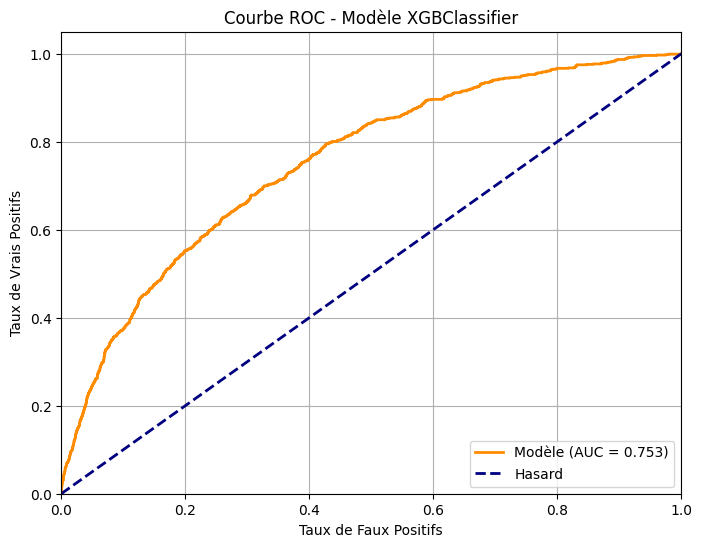

In [41]:
gs_os_pipeline, val_auc, fig, val_cost = pipeline_model_gs_os(XGBClassifier(), X_train_small, y_train_small, X_val_small, y_val_small)
score_model_df = pd.concat([score_model_df, pd.DataFrame([{
    "Modèle": "XGBClassifier_GS_OS",
    "AUC": val_auc,
    "Score métier": val_cost
}])], ignore_index=True)

Hyperparamètres pour RandomForestClassifier : {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10, None], 'model__class_weight': ['balanced', None]}


2026/01/25 21:03:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 12 candidates, totalling 60 fits


2026/01/25 21:19:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/25 21:20:18 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.
2026/01/25 21:20:20 WARNING mlflow.utils.autol

Meilleur coût métier moyen sur le CV : 5233.20


2026/01/25 21:20:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_project\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/25 21:20:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\OC_projec

Score AUC sur validation : 0.6667
Coût Métier sur validation : 8621 €


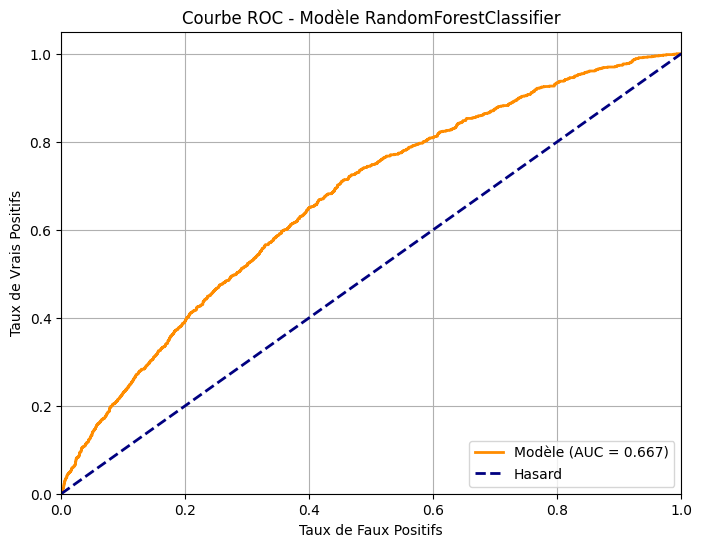

In [42]:
gs_ds_rfpipeline, val_auc, fig, val_cost = pipeline_model_gs_os(RandomForestClassifier(), X_train_small, y_train_small, X_val_small, y_val_small)
score_model_df = pd.concat([score_model_df, pd.DataFrame([{
    "Modèle": "RandomForestClassifier_GS_OS",
    "AUC": val_auc,
    "Score métier": val_cost
}])], ignore_index=True)

In [43]:
print(score_model_df.sort_values(by='Score métier'))

                           Modèle       AUC Score métier
0                        LightGBM  0.770800         6262
1                XGBClassifier_GS  0.767933         6320
2             XGBClassifier_SMOTE  0.729417         6320
3    RandomForestClassifier_SMOTE  0.704016         6320
10            XGBClassifier_GS_OS  0.753245         6662
4       RandomForestClassifier_GS  0.734422         6803
11   RandomForestClassifier_GS_OS  0.666656         8621
5            XGBClassifier_simple  0.733200         9480
6           LogisticRegression_GS  0.747297         9584
7       LogisticRegression_simple  0.750616         9607
8                  LightGBM_smote  0.771996         9656
9   RandomForestClassifier_simple  0.692354         9921


Le meilleur modèle dans notre cas est donc le LightGBM optimisé via un gridsearch. Je dois récupérer ce modèle et l'entrainer sur l'ensemble des données de training.

In [25]:
print (best_lgbmmodel.get_params())

{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 0.02, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': 1, 'num_leaves': 34, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [26]:
best_params = {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 0.02, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': 1, 'num_leaves': 34, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 0}

In [27]:
def lightgbm_model(X_train, y_train, X_val, y_val, best_params):
    model_name = "LGBMClassifier"
    
    with mlflow.start_run(run_name=f"Final_{model_name}", nested=True) as child_run:
        # Preprocessing
        preprocessor = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        X_train_proc = preprocessor.fit_transform(X_train)
        X_val_proc = preprocessor.transform(X_val)
        
        # Log du tag MLflow
        mlflow.set_tag("model_type", model_name)
        
        # Création du modèle avec les meilleurs paramètres
        lgbm = lgb.LGBMClassifier(
            **best_params
        )
        
        print(f"🚀 Entraînement du modèle final avec les paramètres : {best_params}")
        
        # Entraînement avec early stopping
        lgbm.fit(
            X_train_proc, y_train,
            eval_set=[(X_val_proc, y_val)],
            eval_metric='auc',
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=50)  # Affiche la progression tous les 50 rounds
            ]
        )
        
        # Log des paramètres dans MLflow
        mlflow.log_params(best_params)
        
        # Prédictions et métriques
        y_val_pred = lgbm.predict(X_val_proc)
        y_val_probs = lgbm.predict_proba(X_val_proc)[:, 1]
        
        val_auc = roc_auc_score(y_val, y_val_probs)
        real_cost_val = calcul_score_metier(y_val, y_val_pred)
        
        # Log des métriques
        mlflow.log_metric("val_auc", val_auc)
        mlflow.log_metric("val_business_cost", real_cost_val)
        
        # Courbe ROC
        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_xlabel('Taux de faux positifs')
        ax.set_ylabel('Taux de vrais positifs')
        ax.set_title(f'Courbe ROC - Modèle {model_name}')
        ax.legend(loc="lower right")
        ax.grid(alpha=0.3)
        
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")
        
        print(f"✅ AUC sur validation : {val_auc:.4f}")
        print(f"✅ Coût métier sur validation : {real_cost_val:.2f}")
        
        return lgbm, preprocessor, val_auc, real_cost_val, fig

In [32]:
def lightgbm_model_save(X_train, y_train, X_val, y_val, best_params):
    model_name = "LGBMClassifier"
    
    with mlflow.start_run(run_name=f"Final_{model_name}", nested=True) as child_run:

        # Preprocessing
        preprocessor = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        X_train_proc = preprocessor.fit_transform(X_train)
        X_val_proc = preprocessor.transform(X_val)
        
        # Log du tag MLflow
        mlflow.set_tag("model_type", model_name)
        
        # Création du modèle avec les meilleurs paramètres
        lgbm = lgb.LGBMClassifier(
            **best_params
        )
        
        print(f"🚀 Entraînement du modèle final avec les paramètres : {best_params}")
        
        # Entraînement avec early stopping
        lgbm.fit(
            X_train_proc, y_train,
            eval_set=[(X_val_proc, y_val)],
            eval_metric='auc',
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=50)  # Affiche la progression tous les 50 rounds
            ]
        )
        
        # Log des paramètres dans MLflow
        mlflow.log_params(best_params)
        
        # Prédictions et métriques
        y_val_pred = lgbm.predict(X_val_proc)
        y_val_probs = lgbm.predict_proba(X_val_proc)[:, 1]
        
        val_auc = roc_auc_score(y_val, y_val_probs)
        real_cost_val = calcul_score_metier(y_val, y_val_pred)
        
        # Log des métriques
        mlflow.log_metric("val_auc", val_auc)
        mlflow.log_metric("val_business_cost", real_cost_val)
        
        # Courbe ROC
        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {val_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
        ax.set_xlabel('Taux de faux positifs')
        ax.set_ylabel('Taux de vrais positifs')
        ax.set_title(f'Courbe ROC - Modèle {model_name}')
        ax.legend(loc="lower right")
        ax.grid(alpha=0.3)
        
        mlflow.log_figure(fig, f"roc_curve_{model_name}.png")
        
#On combine tout pour pouvoir sauvegarder en un seul objet
        final_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', lgbm)
        ])
        
        # 2. Sauvegarde via MLflow (Pour l'historique et l'interface)
        print("💾 Sauvegarde du pipeline complet dans MLflow...")
        mlflow.sklearn.log_model(final_pipeline, artifact_path="model_complet")
        
        import joblib
        joblib.dump(final_pipeline, 'modele_final_complet.pkl')
        print(f"✅ Modèle sauvegardé localement sous 'modele_final_complet.pkl'")

        return lgbm, preprocessor, val_auc, real_cost_val, fig

In [28]:
#Le feature engineering a créé des valeur infini dan sle scolonnes résultant d'un ratio, je cherche où
X_train_numeric = X_train.select_dtypes(include=[np.number])

# Maintenant, on cherche les infinis
inf_columns = X_train_numeric.columns[np.isinf(X_train_numeric).any()]

print(f"Colonnes contenant des valeurs infinies : {list(inf_columns)}")
print(f"Nombre total de valeurs infinies : {np.isinf(X_train_numeric).sum().sum()}")

Colonnes contenant des valeurs infinies : ['PREV_APP_CREDIT_PERC_MAX', 'PREV_APP_CREDIT_PERC_MEAN', 'REFUSED_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_SUM']
Nombre total de valeurs infinies : 31


In [29]:
# Je remplace ces valeurs par des NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)


# Vérification rapide
cols_to_check = ['PREV_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_SUM']
print(X_train[cols_to_check].isin([np.inf, -np.inf]).sum())

PREV_APP_CREDIT_PERC_MAX    0
INSTAL_PAYMENT_PERC_SUM     0
dtype: int64


In [30]:
# Entraînement du modèle final
best_model, preprocessor, val_auc, cost, fig = lightgbm_model(
    X_train, y_train, X_val, y_val, best_params
)

2026/01/29 11:07:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/29 11:08:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site

🚀 Entraînement du modèle final avec les paramètres : {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 0.02, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': 1, 'num_leaves': 34, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 0}
[LightGBM] [Info] Number of positive: 14895, number of negative: 169608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.302481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99384
[LightGBM] [Info] Number of data points in the train set: 184503, number of used features: 724
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scor

c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ AUC sur validation : 0.7848
✅ Coût métier sur validation : 30147.00


In [33]:
save_model, preprocessor, val_auc, cost, fig = lightgbm_model_save(
    X_train, y_train, X_val, y_val, best_params
)

2026/01/29 11:21:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/29 11:21:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site

🚀 Entraînement du modèle final avec les paramètres : {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 0.02, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': 1, 'num_leaves': 34, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 0}
[LightGBM] [Info] Number of positive: 14895, number of negative: 169608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.226273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99384
[LightGBM] [Info] Number of data points in the train set: 184503, number of used features: 724
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scor

c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/29 11:25:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


💾 Sauvegarde du pipeline complet dans MLflow...
✅ Modèle sauvegardé localement sous 'modele_final_complet.pkl'


In [ ]:
#Si besoin pour ne pas relancer tout le modèle
import joblib

save_model = joblib.load('modele_final_complet.pkl')
X_val_proc = save_model.named_steps['preprocessor'].transform(X_val)
y_val_probs = save_model.named_steps['model'].predict_proba(X_val_proc)[:, 1]

In [38]:
X_val_proc = preprocessor.transform(X_val)
y_val_probs = best_model.predict_proba(X_val_proc)[:, 1]

2026/01/29 14:10:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
c:\Users\manon\anaconda3\envs\P7_OC\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMC

In [39]:
def find_best_threshold(a, b, c, y_true, y_probs, cost_function):
    thresholds = np.linspace(a, b, c) # On teste de 0.4 à 0.5
    costs = []
    
    for t in thresholds:
        # On transforme la proba en prédiction binaire selon le seuil t
        y_pred = (y_probs >= t).astype(int)
        # On calcule le coût avec ta fonction existante
        cost = cost_function(y_true, y_pred)
        costs.append(cost)
    
    best_t = thresholds[np.argmin(costs)]
    min_cost = min(costs)
    return best_t, min_cost, thresholds, costs

In [40]:
best_threshold, min_cost, thresholds, costs = find_best_threshold(0, 1, 101, y_val, y_val_probs, calcul_score_metier)

print(f"Seuil optimal : {best_threshold:.2f}")
print(f"Nouveau coût métier minimum : {min_cost}")

Seuil optimal : 0.48
Nouveau coût métier minimum : 30088


Je crée un fichier de config yml pour garder tous les détails du modèle stockés.

In [42]:
import yaml
from datetime import datetime


In [45]:
print(best_params)

{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 0.02, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': 1, 'num_leaves': 34, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [ ]:
# Configuration complète du modèle
model_config = {
    'model': {
        'type': 'LGBMClassifier',
        'version': 'v1.0',
        'trained_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'framework': 'scikit-learn + lightgbm'
    },
    
    'hyperparameters': {
        'boosting_type': 'gbdt',
        'class_weight': 'balanced',
        'colsample_bytree': 0.7,
        'importance_type': 'split',
        'learning_rate': 0.02,
        'max_depth': -1,
        'min_child_samples': 20,
        'min_child_weight': 0.001,
        'n_estimators': 1000,
        'num_leaves': 34,
        'subsample': 0.8,
        'random_state': 42,
        'subsample_for_bin': 200000,
        'n_jobs': 1
    },
    
    'preprocessing': {
        'imputation_strategy': 'median',
        'scaling': 'StandardScaler',
        'object_to_numeric': True
    },
    
    'threshold': {
        'optimal_threshold': 0.48,
        'default_threshold': 0.5,
        'optimization_metric': 'business_cost'
    }}

In [44]:
# Sauvegarder en YAML
with open('model_config.yml', 'w') as f:
    yaml.dump(model_config, f, default_flow_style=False, sort_keys=False, allow_unicode=True)

print("✅ Configuration sauvegardée dans model_config.yml")

✅ Configuration sauvegardée dans model_config.yml
